In [1]:
import numpy as np
import matplotlib.pyplot as plt

from jlinops import _CustomLinearOperator
import jlinops

In [2]:
class Dirichlet2DSym(_CustomLinearOperator):
    """Implements a matrix-free operator R representing the anisotropic discrete gradient of an input vector x
    equipped with Dirichlet boundary conditions. The null space of this operator is spanned by the constant vector,
    and is symmetrized such that R^T R can be diagonalized using a 2-dimensional DCT.
    """
    def __init__(self, grid_shape, device="cpu"):
        
        # Handle grid shape
        self.grid_shape = grid_shape
        m, n = grid_shape
        shape = (2*m*n + m + n, m*n)
        self.M, self.N = self.grid_shape

        if device == "cpu":

            def matvec(x):

                # Reshape the vector into a 2D grid
                grid = x.reshape(self.M, self.N)

                # Compute the x-derivative
                dx = np.zeros((self.M+1, self.N))
                dx[1:-1, :] = grid[1:, :] - grid[:-1, :]
                dx[-1, :] = - grid[-1,:]
                dx[0, :] = grid[0,:]

                # Compute the y-derivative
                dy = np.zeros((self.M, self.N+1))
                dy[:, 1:-1] = grid[:, 1:] - grid[:, :-1]
                dy[:, -1] = -grid[:, -1]
                dy[:, 0] = grid[:, 0]

                # Flatten and combine the derivatives
                return np.hstack((dx.ravel(), dy.ravel()))

            def rmatvec(y):
                
                # The length of the x-derivative and y-derivative vectors
                len_dx = (self.M + 1) * self.N
                len_dy = self.M * (self.N + 1)
                
                # Extract the derivatives from y
                dx = y[:len_dx].reshape((self.M + 1, self.N))
                dy = y[len_dx:len_dx + len_dy].reshape((self.M, self.N + 1))
                
                # Compute the negative divergence from dx and dy
                # Initialize divergence grid with zeros
                div = np.zeros((self.M, self.N))
                
                # Compute divergence from the x-derivative
                div[:-1, :] -= dx[1:-1, :]
                div[1:, :] += dx[1:-1, :]
                div[-1, :] -= dx[-1, :]
                div[0, :] += dx[0, :]
                
                # Compute divergence from the y-derivative
                div[:, :-1] -= dy[:, 1:-1]
                div[:, 1:] += dy[:, 1:-1]
                div[:, -1] -= dy[:, -1]
                div[:, 0] += dy[:, 0]

                # Return the flattened divergence
                return div.ravel()

        else:
    
            def matvec(x):

                # Reshape the vector into a 2D grid
                grid = x.reshape(self.M, self.N)

                # Compute the x-derivative
                dx = cp.zeros((self.M+1, self.N))
                dx[1:-1, :] = grid[1:, :] - grid[:-1, :]
                dx[-1, :] = - grid[-1,:]
                dx[0, :] = grid[0,:]

                # Compute the y-derivative
                dy = cp.zeros((self.M, self.N+1))
                dy[:, 1:-1] = grid[:, 1:] - grid[:, :-1]
                dy[:, -1] = -grid[:, -1]
                dy[:, 0] = grid[:, 0]

                # Flatten and combine the derivatives
                return cp.hstack((dx.ravel(), dy.ravel()))
            

            def rmatvec(y):
                
                # The length of the x-derivative and y-derivative vectors
                len_dx = (self.M + 1) * self.N
                len_dy = self.M * (self.N + 1)
                
                # Extract the derivatives from y
                dx = y[:len_dx].reshape((self.M + 1, self.N))
                dy = y[len_dx:len_dx + len_dy].reshape((self.M, self.N + 1))
                
                # Compute the negative divergence from dx and dy
                # Initialize divergence grid with zeros
                div = cp.zeros((self.M, self.N))
                
                # Compute divergence from the x-derivative
                div[:-1, :] -= dx[1:-1, :]
                div[1:, :] += dx[1:-1, :]
                div[-1, :] -= dx[-1, :]
                div[0, :] += dx[0, :]
                
                # Compute divergence from the y-derivative
                div[:, :-1] -= dy[:, 1:-1]
                div[:, 1:] += dy[:, 1:-1]
                div[:, -1] -= dy[:, -1]
                div[:, 0] += dy[:, 0]

                # Return the flattened divergence
                return div.ravel()
                

        super().__init__(shape, matvec, rmatvec, device=device, dtype=np.float64)


    def to_gpu(self):
        return Dirichlet2DSym(self.grid_shape, device="gpu")

    def to_cpu(self):
        return Dirichlet2DSym(self.grid_shape, device="cpu")


In [3]:
m, n = 3, 5
R = Dirichlet2DSym((m,n))

In [4]:
3*5

15

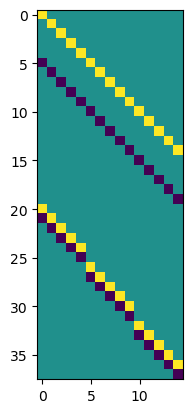

In [5]:
plt.imshow( jlinops.black_box_to_dense(R) )
plt.show()

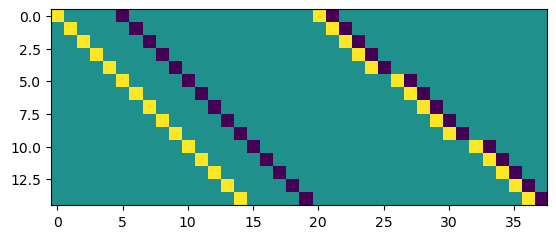

In [6]:
plt.imshow( jlinops.black_box_to_dense(R.T) )
plt.show()

In [7]:
jlinops.check_adjoint(R)

True

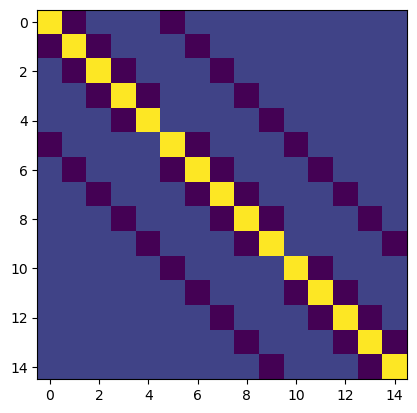

In [8]:
plt.imshow( jlinops.black_box_to_dense(R.T @ R) )
plt.show()

In [15]:
Rmat = jlinops.build_dirichlet2dsym_sparse_matrix((m,n))
Rmat = Rmat.toarray()

/Users/jonathanlindbloom/opt/miniconda3/envs/jlinops/lib/python3.11/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


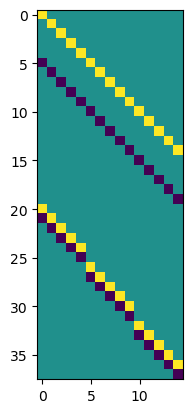

In [16]:
plt.imshow(Rmat)
plt.show()